In [60]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
from sklearn import preprocessing
import pandas as pd
import psycopg2
import faiss
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec
from gensim.utils import simple_preprocess
from psycopg2.extras import execute_values
import pickle
from tensorflow.keras.utils import plot_model
from faiss import write_index
import matplotlib as mpl

params = {'legend.fontsize': 10,
         'axes.labelsize': 10,
         'xtick.labelsize':10,
         'ytick.labelsize':10,
         'axes.grid':True}
mpl.rcParams.update(params)

# Load question embeddings

In [13]:
question_embeddings_model = Doc2Vec.load("python.doc")

# Create Dataset

In [14]:
connection = psycopg2.connect(
    user="postgres",
    password="postgres",
    host="127.0.0.1",
    port="54320",
    database="stack_overflow",
)

In [15]:
tag = "python"
until_date = "2022-01-01"
# answers_samples = 12000
not_answers_samples = 2000000

In [16]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            f"""select count(1)
        from posts_19 p
        join posts_19_tags pt on pt.post_id=p.id
        join tags t on pt.tag_id=t.id
        join posts_19 q_a ON q_a.parent_id = p.id
        where p.body_text is not null
        and p.post_type_id=1 
        and q_a.post_type_id=2 
        and p.creation_date < '{until_date}'
        and t.tag_name = '{tag}'"""
        )
        total_answers = cursor.fetchall()
total_answers

[(1124030,)]

In [17]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            f"""select p.id, q_a.owner_user_id
                    from posts_19 p
                    join posts_19_tags pt on pt.post_id=p.id
                    join tags t on pt.tag_id=t.id
                    join posts_19 q_a ON q_a.parent_id = p.id
                    where p.body_text is not null
                    and p.post_type_id=1 
                    and q_a.post_type_id=2 
                    and q_a.owner_user_id is not NULL
                    and p.creation_date < '{until_date}'
                    and t.tag_name = '{tag}'
                    and p.id in %s""",
            # limit {answers_samples}""",
            (tuple(question_embeddings_model.dv.index_to_key),),
        )
        answers_dataset = pd.DataFrame(
            cursor.fetchall(), columns=["question_id", "user_id"]
        )
        answers_dataset["is_answer"] = 1

In [18]:
len(answers_dataset)

1114213

In [19]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            f"""select p.id, q_a.owner_user_id
                from posts_19 q_a, posts_19 p
                join posts_19_tags pt on pt.post_id=p.id
                join tags t on pt.tag_id=t.id
                where p.body_text is not null
                and random() <= 0.001
                and p.post_type_id=1
                and q_a.post_type_id=2
                and q_a.parent_id != p.id
                and q_a.owner_user_id is not NULL
                and p.creation_date < '{until_date}'
                and t.tag_name = '{tag}'
                and p.id in %s
                limit {not_answers_samples}""",
            (tuple(question_embeddings_model.dv.index_to_key),),
        )
        not_answers_dataset = pd.DataFrame(
            cursor.fetchall(), columns=["question_id", "user_id"]
        )
        not_answers_dataset["is_answer"] = 0

In [20]:
dataset = pd.concat([answers_dataset, not_answers_dataset])

print(len(dataset))
dataset.head(5)

3114213


,question_id,user_id,is_answer
0,55641539,3443106,1
1,55641550,9161389,1
2,55641550,10317656,1
3,55660542,9273718,1
4,55642036,9462829,1


In [21]:
test_size = 0.05

trainset, testset = train_test_split(dataset, test_size=test_size, random_state=42)
len(testset), len(trainset)

(155711, 2958502)

## Encode answers, questions and users

In [22]:
user_encoder = preprocessing.LabelEncoder()
user_encoder.fit(dataset["user_id"])
users_train = user_encoder.transform(trainset["user_id"])

user_embedding_dim = 10
total_users = len(user_encoder.classes_)
total_users

253517

In [23]:
question_encoder = preprocessing.LabelEncoder()
question_encoder.fit(dataset["question_id"])
questions_train = question_encoder.transform(trainset["question_id"])

total_questions = len(question_encoder.classes_)
total_questions

878637

In [30]:
answer_distances_train = 2 * (1 - trainset["is_answer"])

# Create distance model

In [34]:
embedding_matrix = np.zeros(
    (len(question_encoder.classes_), question_embeddings_model.dv.vector_size)
)
for idx, q_id in enumerate(question_encoder.classes_):
    embedding_matrix[idx] = question_embeddings_model.dv[str(q_id)]

In [35]:
p_dropout = 0.3
transformation_1l_neurons = 25

user_id = tf.keras.layers.Input(shape=(), name="user_id")
normalized_user_embedding = tf.keras.layers.Embedding(
    total_users,
    user_embedding_dim,
    embeddings_constraint=tf.keras.constraints.UnitNorm(axis=1),
    trainable=True,
    name="normalized_user_embedding",
)(user_id)

question_id = tf.keras.layers.Input(shape=(), name="question_id")
question_embedding = tf.keras.layers.Embedding(
    total_questions,
    question_embeddings_model.dv.vector_size,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
    name="question_embedding",
)(question_id)

question_transform_l01 = tf.keras.layers.Dense(
    transformation_1l_neurons, activation="sigmoid", name="question_transform_l01"
)(question_embedding)
question_transform_l02 = tf.keras.layers.Dropout(
    p_dropout, name="question_transform_l02"
)(question_transform_l01)
question_in_user_dim = tf.keras.layers.Dense(
    user_embedding_dim, activation="tanh", name="question_in_user_dim"
)(question_transform_l02)

normalized_question_in_user_dim = tf.keras.layers.Lambda(
    lambda x: K.l2_normalize(x, axis=1), name="normalized_question_in_user_dim"
)(question_in_user_dim)
embeddings_difference = tf.keras.layers.Subtract(name="embeddings_difference")(
    [normalized_user_embedding, normalized_question_in_user_dim]
)

embeddings_distance = tf.keras.layers.Lambda(
    lambda x: tf.norm(x, axis=1), name="embeddings_distance"
)(embeddings_difference)
distance_model = tf.keras.models.Model(
    inputs=[user_id, question_id], outputs=embeddings_distance, name="distance_model"
)
distance_model.summary()

Model: "distance_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 question_id (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 question_embedding (Embedding)  (None, 50)          43931850    ['question_id[0][0]']            
                                                                                                  
 question_transform_l01 (Dense)  (None, 25)          1275        ['question_embedding[0][0]']     
                                                                                                  
 question_transform_l02 (Dropou  (None, 25)          0           ['question_transform_l01[0][0]'] 
 t)                                                                                  

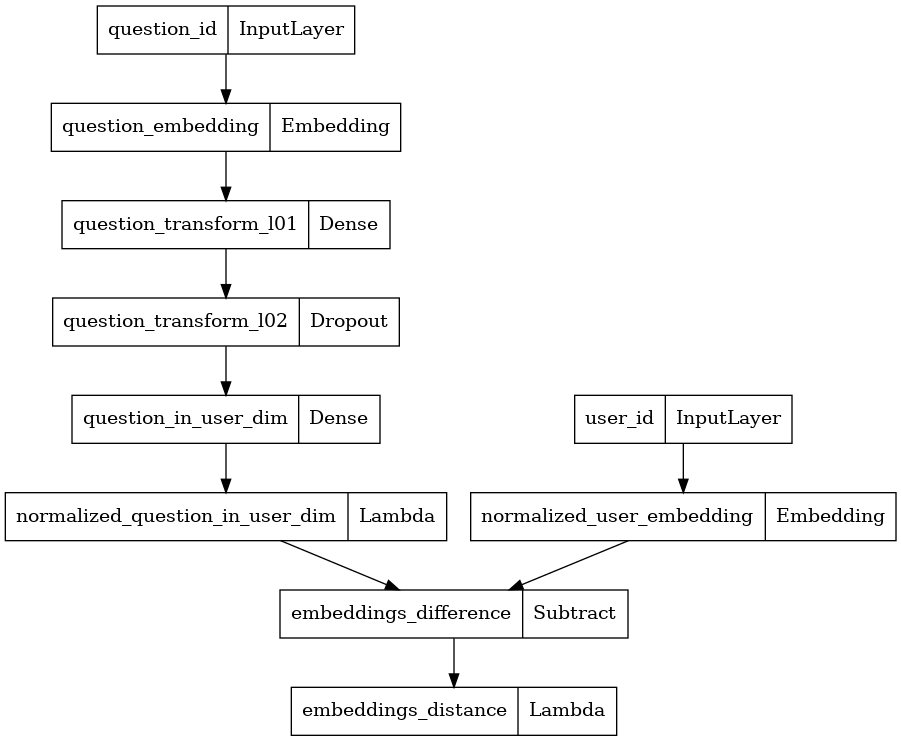

In [36]:
plot_model(distance_model)  # Include dims

In [37]:
distance_model.compile(optimizer="rmsprop", loss="mse")

## Fit distance model

In [38]:
epochs_to_train = 30
validation_split = 0.05
batch_size = 128

history = distance_model.fit(
    [users_train, questions_train],
    answer_distances_train,
    validation_split=validation_split,
    epochs=epochs_to_train,
    batch_size=batch_size,
)

Epoch 1/30
21958/21958 [==============================] - 267s 12ms/step - loss: 0.6095 - val_loss: 0.5207
Epoch 2/30
21958/21958 [==============================] - 267s 12ms/step - loss: 0.4918 - val_loss: 0.4692
Epoch 3/30
21958/21958 [==============================] - 269s 12ms/step - loss: 0.4489 - val_loss: 0.4372
Epoch 4/30
21958/21958 [==============================] - 271s 12ms/step - loss: 0.4197 - val_loss: 0.4144
Epoch 5/30
21958/21958 [==============================] - 261s 12ms/step - loss: 0.3975 - val_loss: 0.3966
Epoch 6/30
21958/21958 [==============================] - 262s 12ms/step - loss: 0.3797 - val_loss: 0.3821
Epoch 7/30
21958/21958 [==============================] - 262s 12ms/step - loss: 0.3646 - val_loss: 0.3697
Epoch 8/30
21958/21958 [==============================] - 252s 11ms/step - loss: 0.3515 - val_loss: 0.3595
Epoch 9/30
21958/21958 [==============================] - 252s 11ms/step - loss: 0.3400 - val_loss: 0.3499
Epoch 10/30
21958/21958 [============

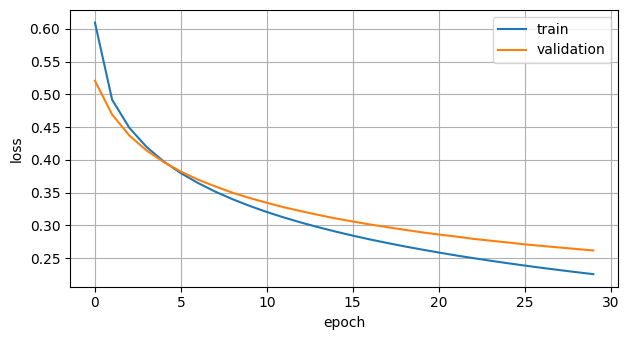

In [70]:
fig, ax1 = plt.subplots()

fig.set_figheight(3.5)

ax1.plot(history.history["loss"])
ax1.plot(history.history["val_loss"])
ax1.set_ylabel("loss")
ax1.set_xlabel("epoch")
ax1.legend(["train", "validation"])
fig.tight_layout()
fig.savefig("user_emb_loss.pdf")
plt.show()

In [40]:
users_test = user_encoder.transform(testset["user_id"])
questions_test = question_encoder.transform(testset["question_id"])
answer_distances_test = 4 * (1 - testset["is_answer"])

In [41]:
distance_model.evaluate([users_test, questions_test], answer_distances_test)

4866/4866 [==============================] - 4s 734us/step - loss: 2.9020


2.9020259380340576

## Store users embeddings

In [97]:
with open("user_embeddings.pickle", "wb") as f:
    pickle.dump(
        (
            distance_model.get_layer("normalized_user_embedding").get_weights()[0],
            user_encoder,
        ),
        f,
    )

# Create users index

In [98]:
(distance_model.get_layer("normalized_user_embedding").get_weights()[0] ** 2).sum(
    axis=1
)

array([0.9999999 , 0.99999976, 0.9999999 , ..., 0.9999998 , 0.9999998 ,
       0.9999998 ], dtype=float32)

In [99]:
index_type = "IDMap,Flat"
index = faiss.index_factory(user_embedding_dim, index_type)


index.train(distance_model.get_layer("normalized_user_embedding").get_weights()[0])
index.add_with_ids(
    distance_model.get_layer("normalized_user_embedding").get_weights()[0],
    user_encoder.classes_,
)

## Store index

In [100]:
write_index(index, "users_imp.index")

# Create question transformation

In [101]:
question_transformer_model = tf.keras.models.Model(
    inputs=distance_model.get_layer("question_embedding").output,
    outputs=distance_model.get_layer("normalized_question_in_user_dim").output,
    name="question_transformer_model",
)

question_transformer_model.summary()

Model: "question_transformer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50)]              0         
                                                                 
 question_transform_l01 (Den  (None, 25)               1275      
 se)                                                             
                                                                 
 question_transform_l02 (Dro  (None, 25)               0         
 pout)                                                           
                                                                 
 question_in_user_dim (Dense  (None, 10)               260       
 )                                                               
                                                                 
 normalized_question_in_user  (None, 10)               0         
 _dim (Lambda)                          

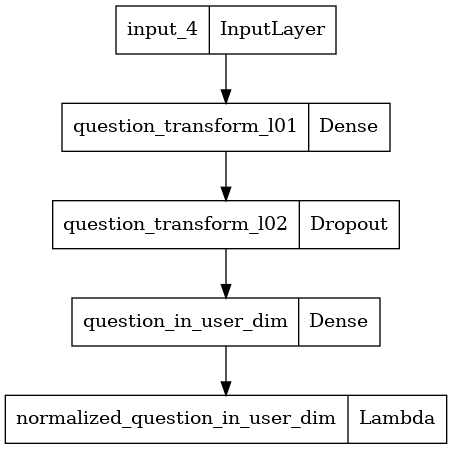

In [102]:
plot_model(question_transformer_model)

## Store questions transformation

In [103]:
question_transformer_model.save("question_transformer_model")

INFO:tensorflow:Assets written to: question_transformer_model/assets


2024-05-15 00:28:22.404156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,25]
	 [[{{node inputs}}]]
2024-05-15 00:28:22.489506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,25]
	 [[{{node inputs}}]]


# Calculate recall

## Make dataset

In [49]:
MIN_ANSWERS = 9
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            f"""select p.id, p.title, p.body_text
        from posts_19 p
        join posts_19_tags pt on pt.post_id=p.id
        join posts_19 a on a.parent_id=p.id
        join tags t on pt.tag_id=t.id
        where p.body_text is not null
        and p.creation_date < '2022-01-01'
        and t.tag_name = 'python'
        group by p.id
        HAVING count(*) > {MIN_ANSWERS}
        limit 3000"""
        )
        posts = cursor.fetchall()

In [104]:
posts_vectors = []
posts_ids = []
for p_id, title, body in posts:
    posts_ids.append(p_id)
    post_text = body
    if title is not None:
        post_text = title + "\n\n" + body
    posts_vectors.append(
        question_embeddings_model.infer_vector(simple_preprocess(post_text))
    )

In [105]:
posts_vectors = np.array(posts_vectors)
posts_vectors.shape

(1371, 50)

In [106]:
questions_transformed = question_transformer_model.predict(posts_vectors)
questions_transformed.shape

43/43 [==============================] - 0s 674us/step


(1371, 10)

## Calculate recall

In [107]:
def get_recall_dist(features_df):
    with connection:
        with connection.cursor() as cursor:
            execute_values(
                cursor,
                """
                                    with base_recs as (
                                        select q_id, u_id
                                        FROM (VALUES %s) AS base_data (q_id, u_id)
                                    ),
                                    answers_per_question as (
                                        select a.parent_id as q_id, count(*) as answers
                                        FROM posts_19 a
                                        WHERE a.parent_id in (select distinct q_id FROM base_recs)
                                        GROUP BY a.parent_id),
                                    retrieved_answers_per_question as (
                                        select a.parent_id as q_id, count(*) as answers
                                        FROM posts_19 a
                                        JOIN base_recs on q_id = a.parent_id
                                        WHERE a.owner_user_id = base_recs.u_id
                                        GROUP BY a.parent_id)
                                    
                                    select COALESCE(retrieved_answers_per_question.answers, 0) / answers_per_question.answers::float
                                    FROM answers_per_question 
                                    LEFT JOIN retrieved_answers_per_question
                                    ON answers_per_question.q_id = retrieved_answers_per_question.q_id""",
                features_df[["q_id", "u_id"]].values.tolist(),
                page_size=len(features_df),
            )
            recalls = np.array(cursor.fetchall()).flatten()
    return recalls.mean(), recalls.std()

In [108]:
distances, similar_questions = index.search(questions_transformed[:3], 15)
features_df = pd.DataFrame(
    list(zip(posts_ids, similar_questions)), columns=["q_id", "u_id"]
).explode("u_id")
features_df["u_id"] = features_df["u_id"].astype(int)
features_df = pd.concat(
    [
        features_df,
        pd.DataFrame(
            [
                (3061, 25450),
                (3061, 5532667),
                (22676, 14927325),
                (22676, 15760624),
                (22676, 394),
            ],
            columns=["q_id", "u_id"],
        ),
    ]
)

In [109]:
get_recall_dist(features_df)

(0.13203463203463203, 0.09429879182161023)

In [110]:
test_k = [50, 100, 200, 350, 500] +list(range(1000,50001,1000))
recall_dist = []
for k in test_k:
    distances, cand_users = index.search(questions_transformed[:50], k)
    features_df = pd.DataFrame(
        list(zip(posts_ids, cand_users)), columns=["q_id", "u_id"]
    ).explode("u_id")
    features_df["u_id"] = features_df["u_id"].astype(int)
    recall_dist.append(get_recall_dist(features_df))
recall_dist = np.array(recall_dist)

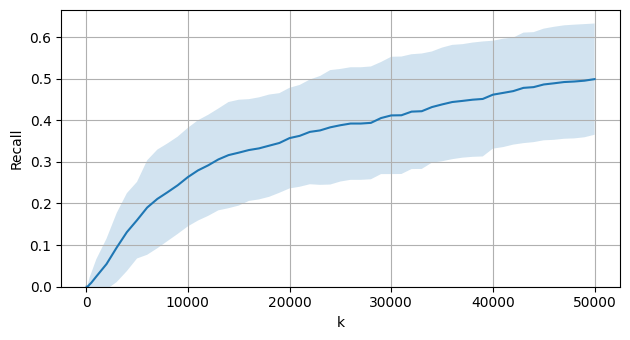

In [111]:
fig, ax1 = plt.subplots()

fig.set_figheight(3.5)
color = "tab:blue"
ax1.set_xlabel("k")
ax1.set_ylabel("Recall")
ax1.plot(test_k, recall_dist[:, 0], color=color)
ax1.fill_between(test_k, recall_dist[:, 0] - recall_dist[:, 1], recall_dist[:, 0] + recall_dist[:, 1], alpha=0.2)
ax1.set_ylim(bottom=0)

fig.tight_layout()
fig.savefig("mean_std_recall_user_emb.pdf")
plt.show()

In [112]:
import pickle

with open('mean_std_recall_user_emb.pickle', 'wb') as f:
    pickle.dump((test_k, recall_dist), f)


In [ ]:
with open('mean_std_recall_user_emb.pickle', 'rb') as f:
    test_k, recall_dist = pickle.load(f)